# Model Training

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    TrainerCallback
)
import evaluate
import torch
from torch.nn import BCEWithLogitsLoss
from typing import Optional, Dict
from torch import FloatTensor, tensor
import logging
from sklearn.metrics import classification_report, hamming_loss
from transformers import EvalPrediction

In [2]:
# for uploading model to hub
from huggingface_hub import notebook_login

notebook_login()

## Dataset Preparation

Will be training 3 datasets and comparing performances:
1. original goEmotions dataset
2. goEmotions + other datasets
3. goEmotions + other datasets + textattack data augmentation

In [32]:
random_seed = 1234

In [33]:
labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

label2id = {label:idx for idx, label in enumerate(labels)}
id2label = {idx:label for idx, label in enumerate(labels)}

### Load base model and tokenizer

In [34]:
model_name = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(labels),     
    problem_type="multi_label_classification", # uses BCEWithLogitsLoss by default)
    id2label=id2label,
    label2id=label2id
) 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# padding will be dynamically done in batching with DataCollatorWithPadding
def tokenize_func(examples):
    return tokenizer(examples['text'], truncation=True)

### Load datasets
Will be training 3 different datasets
- goEmotions (go)
- goEmotions + other datasets (merged)
- goEmotions + other datasets + textattack data augmentation (augmented)

In [36]:
# go
# dataset = load_from_disk('./datasets/cleaned_hf/goEmotions_cleaned')
# # merged
# dataset = load_from_disk('./datasets/cleaned_hf/merged_hf')
# augmented
# dataset = load_from_disk('./datasets/cleaned_hf/augmented_hf')

In [37]:
# augmented v2
# dataset = load_from_disk('./datasets/cleaned_hf/augmented_hf_v2')
# augmented v3
dataset = load_from_disk('./datasets/cleaned_hf/augmented_hf_v3')

In [38]:
type(dataset['train']['labels'][1][0])

int

In [39]:
# In order to use BCEWithLogitsLoss, we need to convert labels to float or it'll give errors
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
# https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3
dataset = dataset.cast_column('labels', Sequence(feature=Value(dtype='float32')))

Casting the dataset:   0%|          | 0/147630 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10426 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12721 [00:00<?, ? examples/s]

In [40]:
type(dataset['train']['labels'][1][6])

float

In [41]:
# before shuffle
dataset['train']['text'][:5]

['mean, he is a terrible president. ',
 'Everyone is born an atheist. Some gets afflicted with religion usually via their parents.',
 "I waited 15 jours for this joke, I'm so proud of this community.",
 'Poor kid. He just wanetd to rescue his mum from a nefarious organisation. I hope he gets decent representation.',
 'i feel it is vital to make the most of that day and live it to our fullest potential']

In [42]:
# shuffle training set
dataset['train'] = dataset['train'].shuffle(seed=random_seed)

In [43]:
# after shuffle
dataset['train']['text'][:5]

['He literilly looks like a potato',
 'Mission Control to Doctor Oct',
 "@maaaarit I'm on msn now",
 'Sorry but I didn’t throw in the towel for my co worker. These feelings were present before she entered my life.',
 'No negotiations with terrorists.']

#### Calculate Class Weights

In [44]:
from generate_class_weights import generate_class_weights 

In [45]:
class_weights = generate_class_weights(dataset['train']['labels'], multi_class=False, one_hot_encoded=True)
class_weights

{0: 0.4571267556788625,
 1: 0.8084176632934683,
 2: 0.8290094339622641,
 3: 0.8076746323529411,
 4: 0.6443235977025541,
 5: 1.4488870568837593,
 6: 1.111403878583474,
 7: 0.8513644437267883,
 8: 2.4042407660738716,
 9: 1.2809766763848396,
 10: 0.9295662905500706,
 11: 1.0212085996513656,
 12: 4.936797752808989,
 13: 1.8624161073825503,
 14: 0.5511132016306052,
 15: 0.6892156862745098,
 16: 22.726293103448278,
 17: 0.567545748116254,
 18: 0.7408318111563861,
 19: 9.63893967093236,
 20: 0.7537526804860615,
 21: 14.686629526462395,
 22: 1.4139179404666131,
 23: 0.979654403567447,
 24: 2.803030303030303,
 25: 0.4348453608247423,
 26: 0.49829883753898496,
 27: 0.24986967442301314}

#### Tokenization

In [46]:
# tokenize in batch
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset

Map:   0%|          | 0/147630 [00:00<?, ? examples/s]

Map:   0%|          | 0/10426 [00:00<?, ? examples/s]

Map:   0%|          | 0/12721 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 147630
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 12721
    })
})

#### Batching and Dynamic padding

In [47]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Training
- Will be using `Trainer` instead of `SFTTrainer` because `SFTTrainer` is often for llms.

In [48]:
training_args = TrainingArguments(
    './models/augmented_v3',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="no",
    push_to_hub=True,
    hub_private_repo=True,
    hub_model_id="augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v3"
    )

#### Compute metrics function

In [49]:
# sources: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    
    # Generate classification report
    report = classification_report(
        y_true=labels,
        y_pred=y_pred,
        output_dict=True,  # Convert report to a dictionary
        zero_division=0  # Avoid division errors for missing labels
    )

    # Extract key metrics
    micro_precision = report["micro avg"]["precision"]
    micro_recall = report["micro avg"]["recall"]
    micro_f1 = report["micro avg"]["f1-score"]

    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    weighted_precision = report["weighted avg"]["precision"]
    weighted_recall = report["weighted avg"]["recall"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    hamming = hamming_loss(y_true, y_pred)

    # Combine all metrics into a dictionary
    metrics = {
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_precision,
        "weighted_recall": weighted_recall,
        "weighted_f1": weighted_f1,
        "hamming_loss": hamming
    }

    return metrics



def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result
    

#### Custom Class Weighting Trainer Class

In [50]:
# Reference: https://discuss.huggingface.co/t/mullti-label-text-classification/44233/3
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights: Optional[Dict[int, float]] = None, processing_class: Optional[AutoTokenizer] = None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            # dict --> FloatTensor
            if isinstance(class_weights, dict):
                # Convert to list of values and then to FloatTensor
                class_weights = tensor(list(class_weights.values()), dtype=torch.float)
                logging.info(f"Converted class_weights to FloatTensor: {class_weights}")
            elif not isinstance(class_weights, FloatTensor):
                raise ValueError("class_weights must be a dict or a FloatTensor")
            class_weights = class_weights.to(self.args.device)

        self.loss_fct = BCEWithLogitsLoss(pos_weight=class_weights)

        # If processing_class is passed, use it
        if processing_class is not None:
            self.processing_class = processing_class  # Handling tokenizer using processing_class argument
        else:
            self.processing_class = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        try:
            loss = self.loss_fct(outputs.logits.view(-1, model.num_labels), labels.view(-1, model.num_labels))
        except AttributeError:  # DataParallel
            loss = self.loss_fct(outputs.logits.view(-1, model.module.num_labels), labels.view(-1, model.num_labels))

        return (loss, outputs) if return_outputs else loss

### Train and Validation

In [51]:
# train_subset = tokenized_dataset["train"].select(range(100))
# eval_subset = tokenized_dataset["validation"].select(range(100))

In [52]:
trainer = WeightedTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [53]:
trainer.train()

  0%|          | 0/55362 [00:00<?, ?it/s]

  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.079988494515419, 'eval_micro_precision': 0.727217496962333, 'eval_micro_recall': 0.48215580439861433, 'eval_micro_f1': 0.5798575788402849, 'eval_macro_precision': 0.6081781313872927, 'eval_macro_recall': 0.38406951425182045, 'eval_macro_f1': 0.44355013200066234, 'eval_weighted_precision': 0.7271418595328578, 'eval_weighted_recall': 0.48215580439861433, 'eval_weighted_f1': 0.5608849297805127, 'eval_hamming_loss': 0.029709380395165932, 'eval_runtime': 26.4188, 'eval_samples_per_second': 394.643, 'eval_steps_per_second': 49.359, 'epoch': 1.0}


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.07796660810709, 'eval_micro_precision': 0.689543763461915, 'eval_micro_recall': 0.5673890276323209, 'eval_micro_f1': 0.6225306050293896, 'eval_macro_precision': 0.5850318382348718, 'eval_macro_recall': 0.4612338790412692, 'eval_macro_f1': 0.49993670117343536, 'eval_weighted_precision': 0.6800136082343471, 'eval_weighted_recall': 0.5673890276323209, 'eval_weighted_f1': 0.6109039189960934, 'eval_hamming_loss': 0.02925721410758817, 'eval_runtime': 26.4091, 'eval_samples_per_second': 394.788, 'eval_steps_per_second': 49.377, 'epoch': 2.0}


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.08218466490507126, 'eval_micro_precision': 0.6805855306371399, 'eval_micro_recall': 0.5843067751550793, 'eval_micro_f1': 0.6287819679237104, 'eval_macro_precision': 0.5709256152329003, 'eval_macro_recall': 0.45528891591933723, 'eval_macro_f1': 0.4949797778010309, 'eval_weighted_precision': 0.6654296731037728, 'eval_weighted_recall': 0.5843067751550793, 'eval_weighted_f1': 0.619575302681865, 'eval_hamming_loss': 0.02933600065769642, 'eval_runtime': 27.0858, 'eval_samples_per_second': 384.925, 'eval_steps_per_second': 48.143, 'epoch': 3.0}
{'train_runtime': 4573.7621, 'train_samples_per_second': 96.833, 'train_steps_per_second': 12.104, 'train_loss': 0.06914460978141596, 'epoch': 3.0}


TrainOutput(global_step=55362, training_loss=0.06914460978141596, metrics={'train_runtime': 4573.7621, 'train_samples_per_second': 96.833, 'train_steps_per_second': 12.104, 'total_flos': 4098695009295264.0, 'train_loss': 0.06914460978141596, 'epoch': 3.0})

In [54]:
# https://youtu.be/Zh0FfmVrKX0?t=147
# push to hub again b/c:
# 1. making sure we are uploading the final version of the model if we didn't already
# 2. draft a model card in the landing page of model repo
trainer.push_to_hub("End of training")

CommitInfo(commit_url='https://huggingface.co/paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v3/commit/4085cb9b401e6c439018c8b3d73cf512008e35eb', commit_message='End of training', commit_description='', oid='4085cb9b401e6c439018c8b3d73cf512008e35eb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v3', endpoint='https://huggingface.co', repo_type='model', repo_id='paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v3'), pr_revision=None, pr_num=None)

In [61]:
# validation evaluation
trainer.evaluate()

  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.08218466490507126,
 'eval_micro_precision': 0.6805855306371399,
 'eval_micro_recall': 0.5843067751550793,
 'eval_micro_f1': 0.6287819679237104,
 'eval_macro_precision': 0.5709256152329003,
 'eval_macro_recall': 0.45528891591933723,
 'eval_macro_f1': 0.4949797778010309,
 'eval_weighted_precision': 0.6654296731037728,
 'eval_weighted_recall': 0.5843067751550793,
 'eval_weighted_f1': 0.619575302681865,
 'eval_hamming_loss': 0.02933600065769642,
 'eval_runtime': 30.0924,
 'eval_samples_per_second': 346.467,
 'eval_steps_per_second': 43.333,
 'epoch': 3.0}

#### Evaluate on test

In [56]:
# test_subset = tokenized_dataset["test"].select(range(100))

In [ ]:
# test
logits, true_labels, metrics = trainer.predict(tokenized_dataset['test'])
metrics

  0%|          | 0/1591 [00:00<?, ?it/s]

{'test_loss': 0.08900844305753708,
 'test_micro_precision': 0.6984362361822594,
 'test_micro_recall': 0.595928226363009,
 'test_micro_f1': 0.6431231380337636,
 'test_macro_precision': 0.553654820028813,
 'test_macro_recall': 0.4597076591007087,
 'test_macro_f1': 0.49479123988804874,
 'test_weighted_precision': 0.6910377034593411,
 'test_weighted_recall': 0.595928226363009,
 'test_weighted_f1': 0.6383573696302827,
 'test_hamming_loss': 0.03228632070704235,
 'test_runtime': 34.604,
 'test_samples_per_second': 367.617,
 'test_steps_per_second': 45.977}

In [63]:
# change logits to pred array
threshold = 0.5
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))
# next, use threshold to turn them into integer predictions
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= threshold)] = 1
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
report = classification_report(true_labels, y_pred, target_names=labels, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

    admiration       0.61      0.66      0.64       504
     amusement       0.73      0.83      0.78       264
         anger       0.79      0.67      0.72      1585
     annoyance       0.39      0.20      0.26       320
      approval       0.44      0.31      0.37       351
        caring       0.38      0.29      0.33       135
     confusion       0.43      0.42      0.43       153
     curiosity       0.47      0.45      0.46       284
        desire       0.51      0.30      0.38        83
disappointment       0.28      0.20      0.23       151
   disapproval       0.41      0.30      0.35       267
       disgust       0.71      0.60      0.65      1222
 embarrassment       0.43      0.27      0.33        37
    excitement       0.40      0.38      0.39       103
          fear       0.78      0.74      0.76       787
     gratitude       0.93      0.88      0.91       352
         grief       0.

Confusion Matrix for label admiration:
[[12004   213]
 [  169   335]]


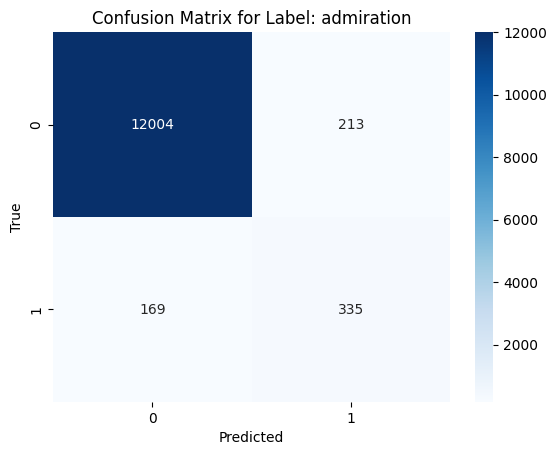

Confusion Matrix for label amusement:
[[12375    82]
 [   44   220]]


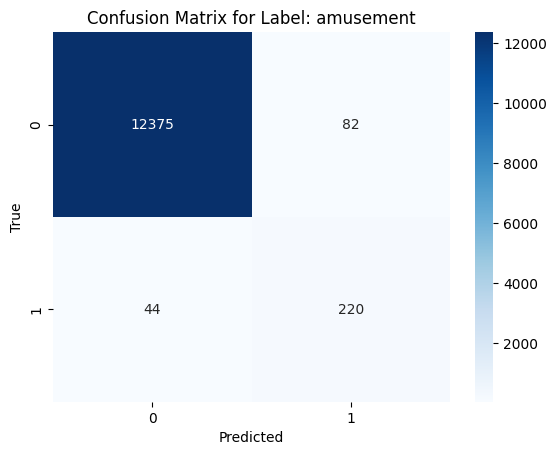

Confusion Matrix for label anger:
[[10861   275]
 [  530  1055]]


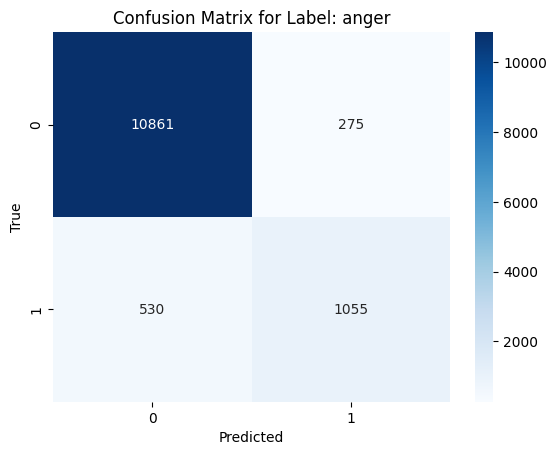

Confusion Matrix for label annoyance:
[[12302    99]
 [  257    63]]


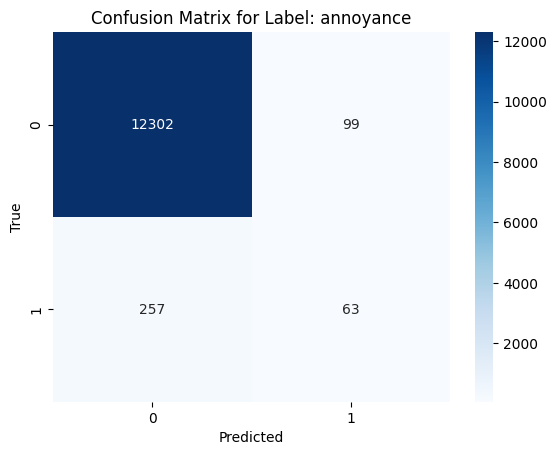

Confusion Matrix for label approval:
[[12231   139]
 [  241   110]]


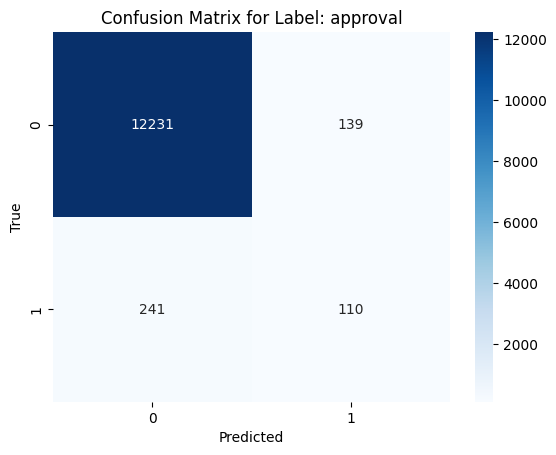

Confusion Matrix for label caring:
[[12523    63]
 [   96    39]]


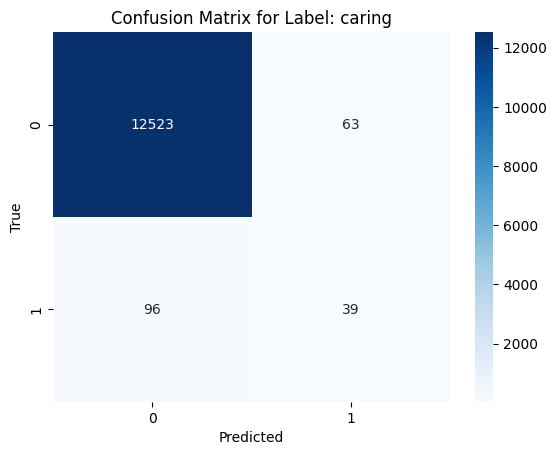

Confusion Matrix for label confusion:
[[12483    85]
 [   88    65]]


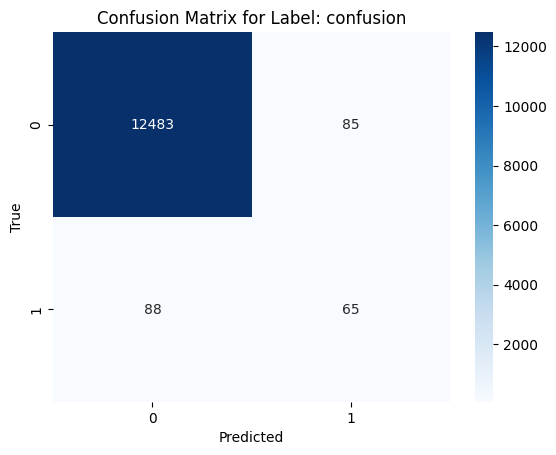

Confusion Matrix for label curiosity:
[[12295   142]
 [  157   127]]


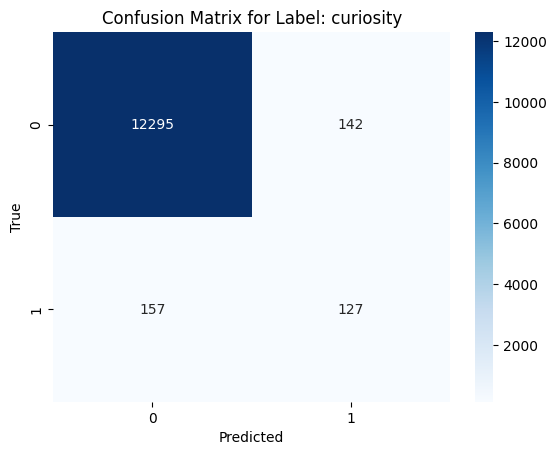

Confusion Matrix for label desire:
[[12614    24]
 [   58    25]]


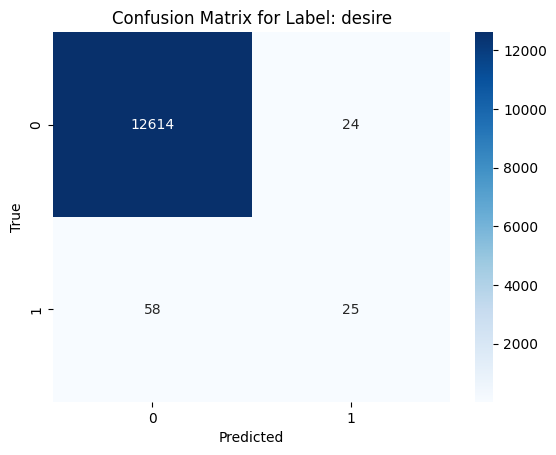

Confusion Matrix for label disappointment:
[[12493    77]
 [  121    30]]


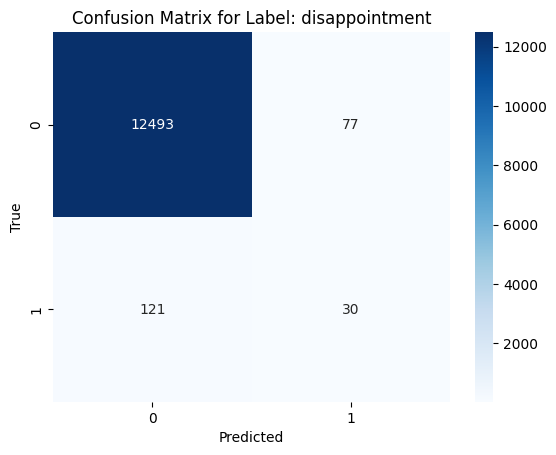

Confusion Matrix for label disapproval:
[[12337   117]
 [  186    81]]


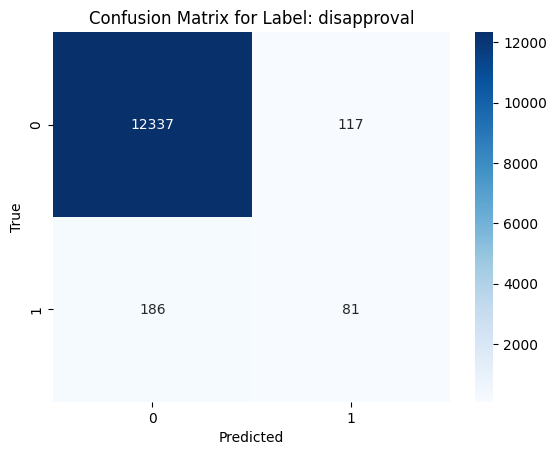

Confusion Matrix for label disgust:
[[11195   304]
 [  483   739]]


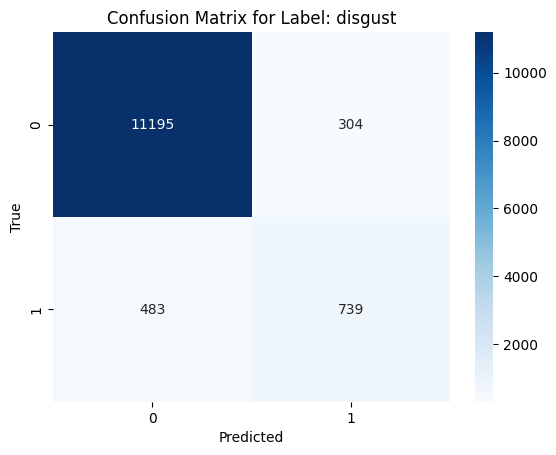

Confusion Matrix for label embarrassment:
[[12671    13]
 [   27    10]]


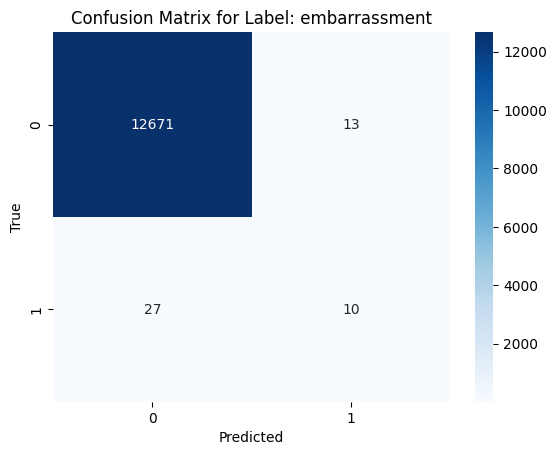

Confusion Matrix for label excitement:
[[12560    58]
 [   64    39]]


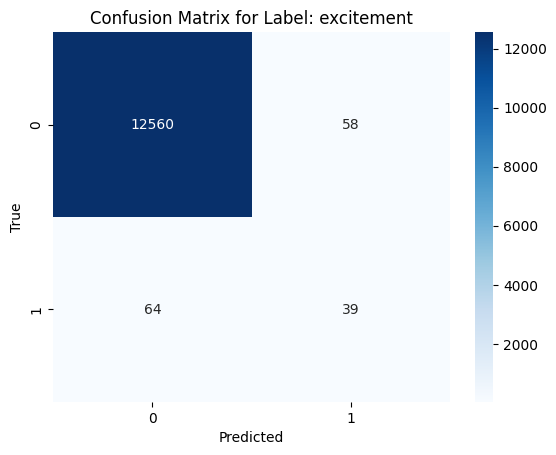

Confusion Matrix for label fear:
[[11768   166]
 [  204   583]]


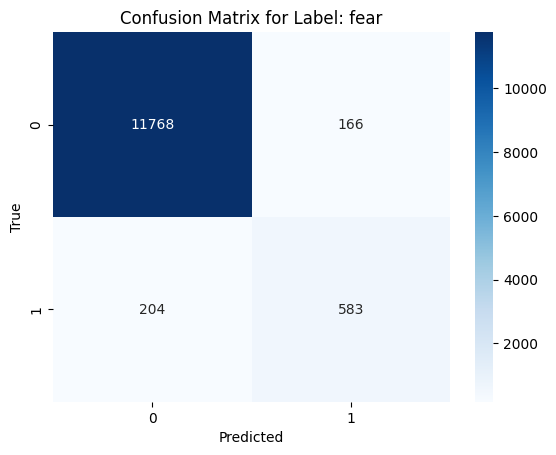

Confusion Matrix for label gratitude:
[[12347    22]
 [   42   310]]


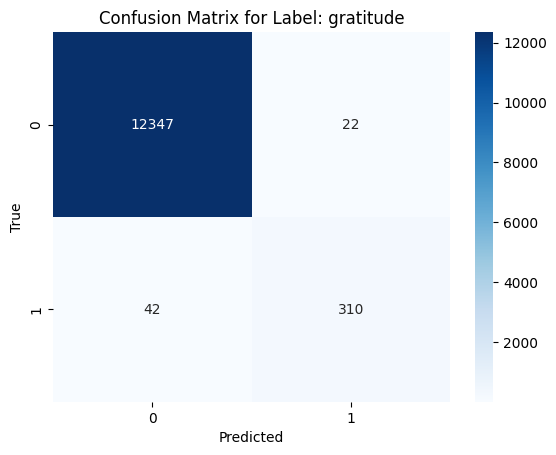

Confusion Matrix for label grief:
[[12714     1]
 [    5     1]]


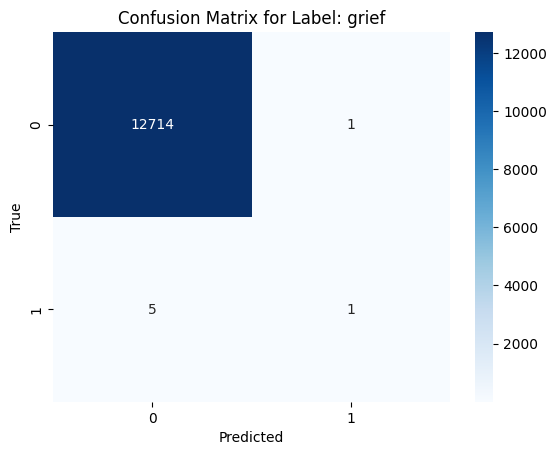

Confusion Matrix for label joy:
[[10190   233]
 [  560  1738]]


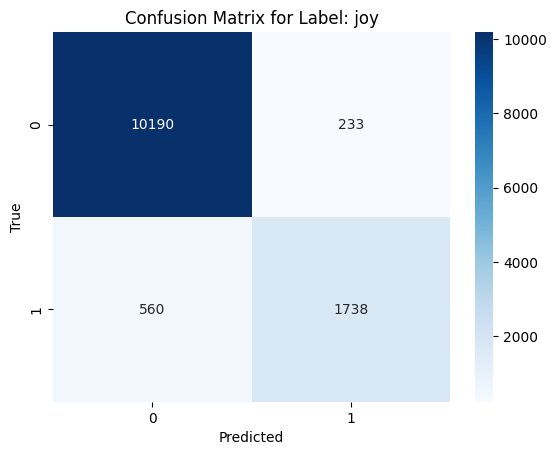

Confusion Matrix for label love:
[[11065   351]
 [  515   790]]


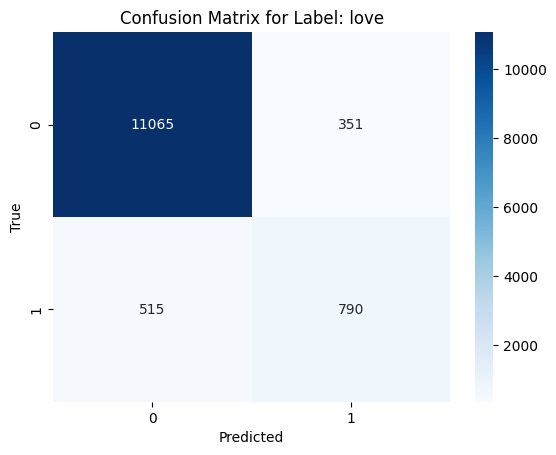

Confusion Matrix for label nervousness:
[[12687    11]
 [   16     7]]


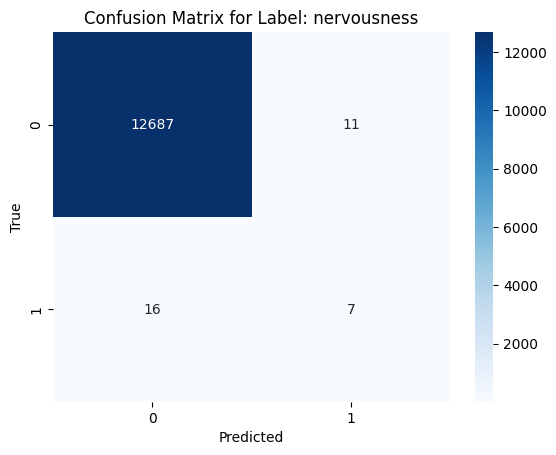

Confusion Matrix for label optimism:
[[11056   336]
 [  552   777]]


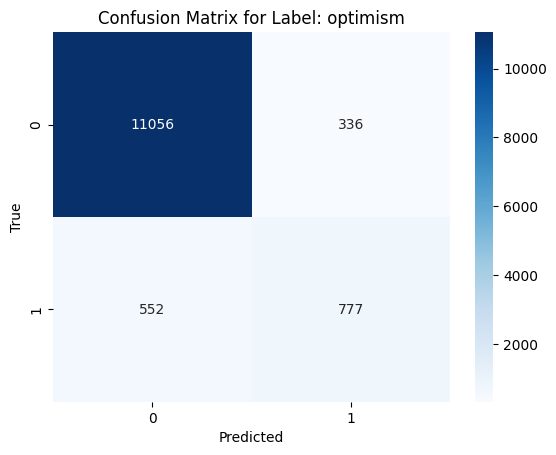

Confusion Matrix for label pride:
[[12702     3]
 [   11     5]]


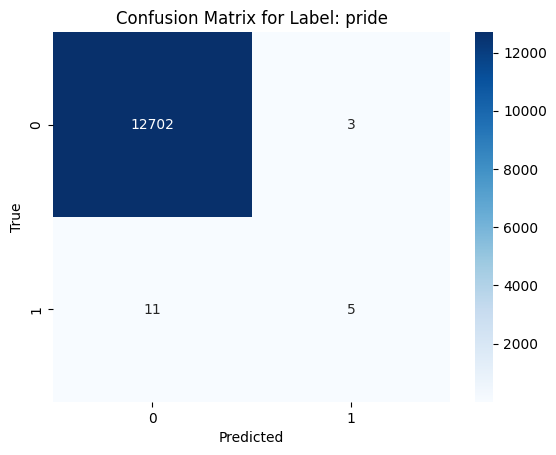

Confusion Matrix for label realization:
[[12527    49]
 [  122    23]]


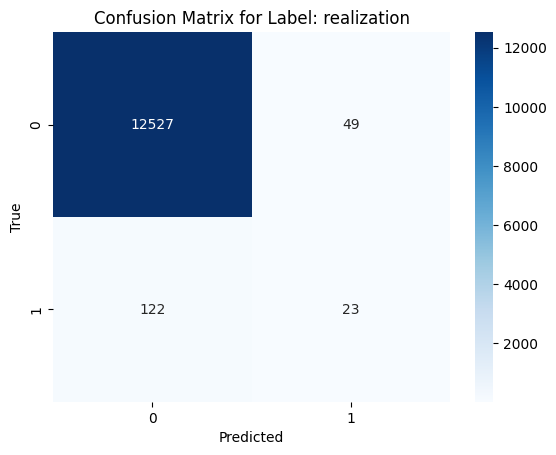

Confusion Matrix for label relief:
[[12456   105]
 [  136    24]]


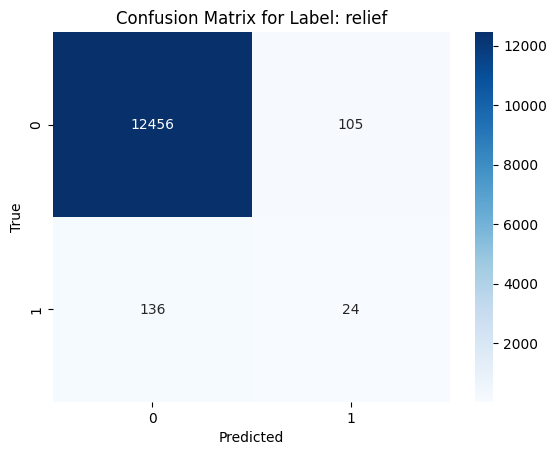

Confusion Matrix for label remorse:
[[12638    27]
 [   14    42]]


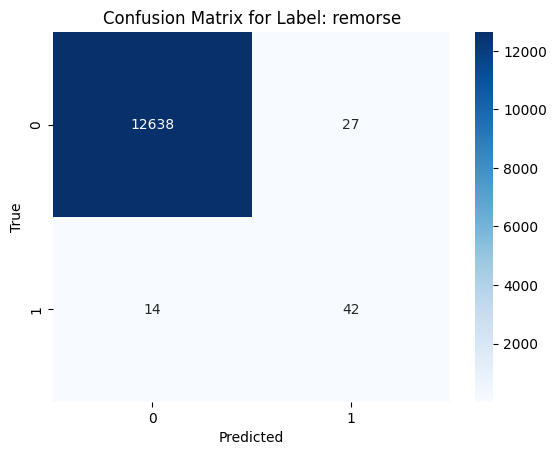

Confusion Matrix for label sadness:
[[10022   487]
 [  742  1470]]


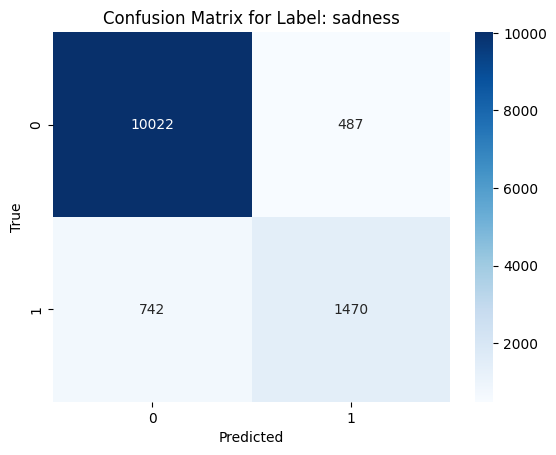

Confusion Matrix for label surprise:
[[11934   215]
 [  364   208]]


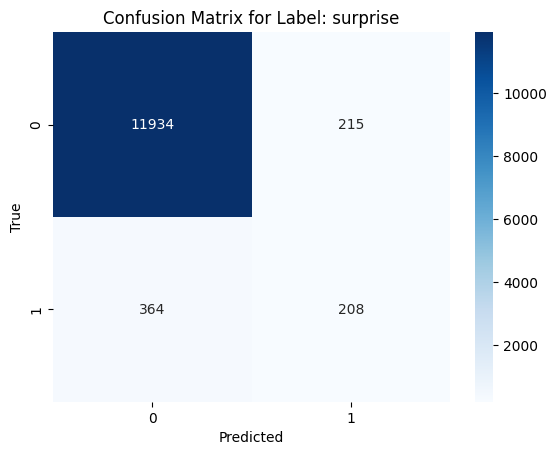

Confusion Matrix for label neutral:
[[9276  777]
 [1222 1446]]


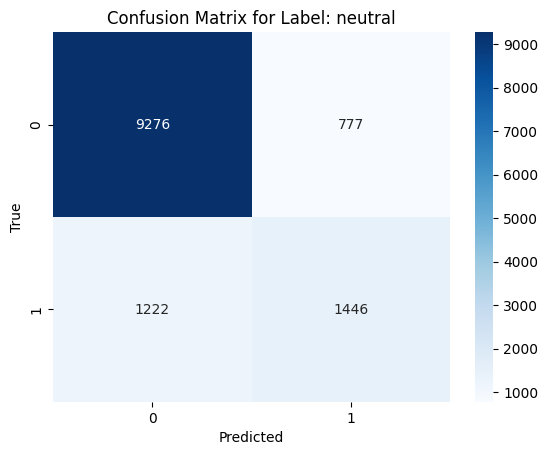

In [60]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mcm = multilabel_confusion_matrix(true_labels, y_pred)

for i in range(mcm.shape[0]):
    print(f"Confusion Matrix for label {labels[i]}:")
    print(mcm[i])
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for Label: {labels[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()